In [1]:
__author__='fbb'

# solution of PUI2016 midterm

In [2]:
import os
import numpy as np
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path

%pylab  inline

Populating the interactive namespace from numpy and matplotlib


# Relation of citibike usage and income

## IRS DATA

### income data from the IRS site is https://www.irs.gov/pub/irs-soi/?C=N;O=D
### file name  14zp33ny.xls
### accessed on 11/08/2016

In [3]:
!curl -O https://www.irs.gov/pub/irs-soi/14zp33ny.xls
# movingto data directory
os.system("mv 14zp33ny.xls " + os.getenv("PUIDATA"))
# reading into a pandas dataframe
incomeByZip = pd.read_excel(os.getenv("PUIDATA") + "/14zp33ny.xls", header=3, index_col="""ZIP\ncode [1]""")
incomeByZip.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8959k  100 8959k    0     0  2116k      0  0:00:04  0:00:04 --:--:-- 2117k


,Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Unnamed: 10,...,Total tax liability [9],Unnamed: 116,Additional Medicare tax,Unnamed: 118,Net investment income tax,Unnamed: 120,Tax due at time of filing [10],Unnamed: 122,Overpayments refunded [11],Unnamed: 124
ZIP code [1],,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Total,Number of volunteer income tax assistance (VIT...,...,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount
NaN,NaN,-1,-2,-3,-4,-5,-6,-7,-8,-9,...,-114,-115,-116,-117,-118,-119,-120,-121,-122,-123
0,Total,9397410,4750550,2942890,1515950,6110600,17322490,5539120,279510,197150,...,7229610,129761061,280780,900175,300410,2745701,1781540,10177242,7115810,25052463
0,"$1 under $25,000",3617400,2432240,468500,665410,2247810,5220510,1678560,187260,136800,...,1804270,1677200,0,0,0,0,451080,361017,2886740,6049923
0,"$25,000 under $50,000",2070870,1103290,449390,467540,1280840,3729240,1219770,69390,49620,...,1769800,4790944,0,0,0,0,287080,461908,1747120,4510472


In [4]:
# extracting Adjusted gross income for every zipcode
# for each zipcode that is the first of the several entries under AGI 
incomeByZip['Adjusted gross income (AGI) [3]'].head()

ZIP\ncode [1]
NaN          NaN
NaN          -11
0      766646080
0       43301874
0       75271045
Name: Adjusted gross income (AGI) [3], dtype: float64

In [5]:
#extract the right entry with iloc[0]: for zipcode 1001.
print ("10001 total AGI:", incomeByZip.loc[[10001]]["Adjusted gross income (AGI) [3]"].iloc[0])


10001 total AGI: 2363960.0


In [6]:
# extract  the zipcodes and make them numerical
zipcs = pd.to_numeric(incomeByZip.index, errors='coerce')
zipcs = zipcs[~np.isnan(zipcs)].astype(int)

In [7]:
# extract only unique zips and see that they are ok
zipincome = pd.DataFrame()
uniquezips = set(zipcs)
zipincome['zipcodes'] = list(uniquezips)
print ("number of unique zipcodesin IRS data", zipincome['zipcodes'].size)

number of unique zipcodesin IRS data 1544


In [8]:
# one option. fairly slow because it runs four list comprehensions

#extact a few relevant entries from dataset
zipincome['income'] = [incomeByZip.loc[[z]]["Adjusted gross income (AGI) [3]"].iloc[0] for z in uniquezips]
zipincome['N'] = [incomeByZip.loc[[z]]["Number of returns"].iloc[0] for z in uniquezips]
zipincome['Njoint'] = [incomeByZip.loc[[z]]["Number of joint returns"].iloc[0] for z in uniquezips]
zipincome['Ndeps'] = [incomeByZip.loc[[z]]["Number of dependents"].iloc[0] for z in uniquezips]
zipincome.head()

,zipcodes,income,N,Njoint,Ndeps
0,0,766646080,9397410,2942890,5539120
1,99999,14338084,88940,28130,43810
2,10001,2363960,14080,2410,3250
3,10002,2215542,43370,11040,19160
4,10003,6910992,29810,5460,4790


In [9]:
# alternative:using .groupby() and .first()
zipincome = incomeByZip.groupby(incomeByZip.index).first()[["Adjusted gross income (AGI) [3]", 
                                                            "Number of returns",
                                                            "Number of joint returns", 
                                                            "Number of dependents"]]
zipincome.rename(columns = {"Adjusted gross income (AGI) [3]":"income", "Number of returns":"N",
                             "Number of joint returns":"Njoint", "Number of dependents":"Ndeps"}, inplace=True)
zipincome.reset_index(inplace=True)
zipincome.rename(columns = {"ZIP\ncode [1]":"zipcodes"}, inplace=True)
zipincome.head()

,zipcodes,income,N,Njoint,Ndeps
0,0,766646080,9397410,2942890,5539120
1,10001,2363960,14080,2410,3250
2,10002,2215542,43370,11040,19160
3,10003,6910992,29810,5460,4790
4,10004,925417,2540,840,1130


In [10]:
#income per person in zipcode
zipincome['incomePC'] = zipincome['income'] / (zipincome.N + zipincome.Ndeps + zipincome.Njoint)
zipincome.head()

,zipcodes,income,N,Njoint,Ndeps,incomePC
0,0,766646080,9397410,2942890,5539120,42.878688
1,10001,2363960,14080,2410,3250,119.754813
2,10002,2215542,43370,11040,19160,30.114748
3,10003,6910992,29810,5460,4790,172.516026
4,10004,925417,2540,840,1130,205.192239


## CITIBIKE DATA

### citibike data for 201506 and 201601, accessed on 11/08 

In [11]:
#download 2015 and 2016 data
datestring = {15:"201506", 16:"201601"}
getCitiBikeCSV(datestring[15])
cb2015 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring[15] + "-citibike-tripdata.csv")
getCitiBikeCSV(datestring[16])
cb2016 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring[16] + "-citibike-tripdata.csv")

file in place, you can continue
file in place, you can continue


In [12]:
cb2015.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984,1
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997,1
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993,1
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981,1
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0


In [13]:
#exract statsions. in this cell checks if it works
latlon = (cb2015[['start station latitude', 
                'start station longitude']].values.astype(float))
print("The number of rows in the 2015 citibike dataset is", len(latlon))

The number of rows in the 2015 citibike dataset is 941219


In [14]:
zipcodesDF = pd.DataFrame()

In [15]:
#this cells reverse geocodes coordinates to zip codes
cb2015['zipcodes'] = np.zeros(len(cb2015))
for ll in pd.DataFrame(latlon).drop_duplicates().values:
    url = ("https://maps.googleapis.com/maps/api/geocode/json?latlng=" +
           "%f,%f&key=%s"%(
            ll[0], ll[1], os.getenv('GOOGLEAPI')))
    #print ("https://maps.googleapis.com/maps/api/geocode/json?latlng=" +
    #       "%f,%f&key=%s"%(
    #        ll[0], ll[1], os.getenv('GOOGLEAPI')))
    #print (get_jsonparsed_data(url))
    revgeo = get_jsonparsed_data(url)["results"][0]['address_components'][-1]
    #print (revgeo)
    cb2015['zipcodes'][(cb2015['start station latitude'] == ll[0]) * 
           (cb2015['start station longitude'] == ll[1])] = revgeo['long_name']
cb2015['zipcodes'] = pd.to_numeric(cb2015['zipcodes'], errors='coerce')
cb2015.head()

//anaconda/lib/python3.5/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/internals.py:4417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,zipcodes
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984,1,2926
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997,1,10003
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993,1,10011
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981,1,5416
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0,4510


In [16]:
# trowing away some bad data
cb2015 = cb2015[cb2015['zipcodes'] >= 10000]

## get rides by zip

In [17]:
#group the rides by zipcode
# I want number of rows per zipcode so I use .count()
cbgroup15 = cb2015.groupby('zipcodes', as_index=False).count()

## merge

In [18]:
#merge rides and income and drop all but one citibike columns
cbincome2015 = pd.merge(cbgroup15, zipincome, on="zipcodes", how="inner").drop(cbgroup15.columns[2:], axis=1)
cbincome2015.head()

,zipcodes,tripduration,income,N,Njoint,Ndeps,incomePC
0,10001,51691,2363960,14080,2410,3250,119.754813
1,10002,45970,2215542,43370,11040,19160,30.114748
2,10003,74663,6910992,29810,5460,4790,172.516026
3,10004,13698,925417,2540,840,1130,205.192239
4,10005,9631,5545849,5890,1340,1340,647.123571


In [19]:
cbincome2015.rename(columns={"tripduration":"Nrides"}, inplace=True)
# ths is the final dataset
cbincome2015.head()

,zipcodes,Nrides,income,N,Njoint,Ndeps,incomePC
0,10001,51691,2363960,14080,2410,3250,119.754813
1,10002,45970,2215542,43370,11040,19160,30.114748
2,10003,74663,6910992,29810,5460,4790,172.516026
3,10004,13698,925417,2540,840,1130,205.192239
4,10005,9631,5545849,5890,1340,1340,647.123571


# ANALYSIS

Text(0,0.5,'Number of rides')

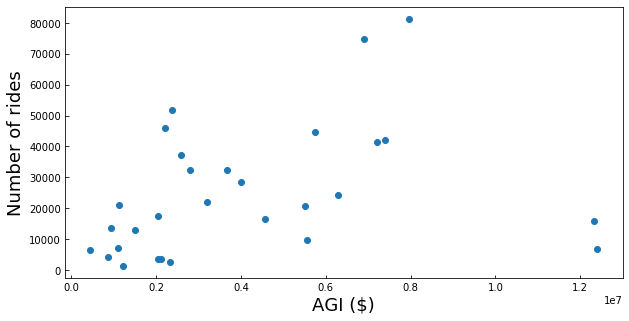

In [20]:
# plotting data
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['income'], cbincome2015['Nrides'], 'o', label="06/2015")
ax.set_xlabel("AGI ($)", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)


### Figure 1: Number of Citibike Rides in 2015/06 as a function of Adjusted Gross Income aggregated at the zipcode level (blue dots).

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.097
Date:                Tue, 08 Nov 2016   Prob (F-statistic):             0.0898
Time:                        22:37:28   Log-Likelihood:                -327.46
No. Observations:                  29   AIC:                             658.9
Df Residuals:                      27   BIC:                             661.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.634e+04   6128.231      2.667      0.013      3767.857  2.89e+04
income         0.0021      0.001      1.760      0.090        -0.000     0.005
==============================================================================
Omnibus:                        3.771   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                2.629
Skew:                           0.730   Prob(JB):                        0.269
Kurtosis:                       3.212   Cond. No.                     8.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

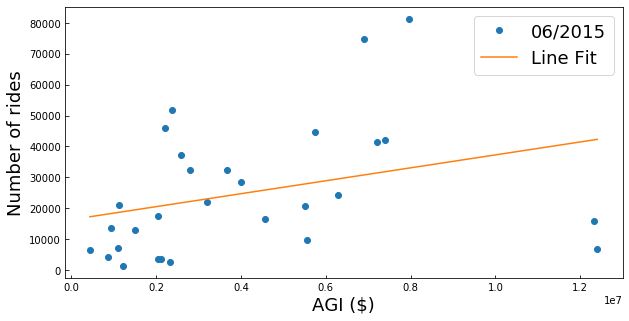

In [21]:
# fit line to data
linmodel2015 = smf.ols(formula = 'Nrides ~ income', data = cbincome2015).fit()

#plot
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['income'], cbincome2015['Nrides'], 'o', label="06/2015")

ax.plot(np.linspace(cbincome2015.income.min(), cbincome2015.income.max(), 100), 
        linmodel2015.predict(exog = dict(income=np.linspace(cbincome2015.income.min(), 
                                                        cbincome2015.income.max(),100))), 
        label="Line Fit")
ax.set_xlabel("AGI ($)", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)
ax.legend(fontsize=18)

#fit summary
linmodel2015.summary()

### Figure 2: Number of Citibike Rides in 2015/06 as a function of Adjusted Gross Income aggregated at the zipcode level (blue dots). The orange line is a line fit obtained with ordinary least square (OLS) method (fit summary above). The model explains less than 10% of the variance in the data.

### selecting outliers to improve the fit

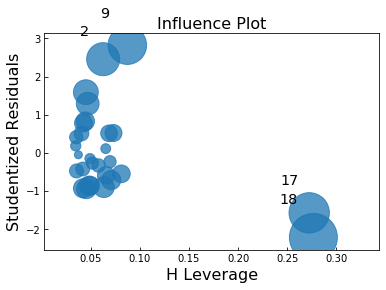

In [22]:
tmp = sm.graphics.influence_plot(linmodel2015)

### Figure 3:  Influence plot of the OLS line fit to number of citibike rides as a function of AGI. This plots guides the choice of outliers: the points at index 17 and 18 have the largerst influence on the fit.

In [23]:
print ("The two datapoints with highest influence on the linear fit")
cbincome2015.iloc[[17,18]]

The two datapoints with highest influence on the linear fit


,zipcodes,Nrides,income,N,Njoint,Ndeps,incomePC
17,10022,15831,12325088,20130,5550,4620,406.768581
18,10023,6832,12398465,33720,9440,9580,235.086557


In [24]:
print ("The two datapoints with highest influence on the linear fit have income > $1.2e7")
print(cbincome2015[cbincome2015.income>1.2e7])

The two datapoints with highest influence on the linear fit have income > $1.2e7
    zipcodes  Nrides    income      N  Njoint  Ndeps    incomePC
17     10022   15831  12325088  20130    5550   4620  406.768581
18     10023    6832  12398465  33720    9440   9580  235.086557


### The high influence points are high income low rides points, located in the bottom right of the plot. They are the only 2 points with AGI > $1.2e7

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     19.21
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           0.000184
Time:                        22:38:09   Log-Likelihood:                -299.12
No. Observations:                  27   AIC:                             602.2
Df Residuals:                      25   BIC:                             604.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4821.5398   5740.298      0.840      0.409     -7000.825  1.66e+04
income         0.0061      0.001      4.383      0.000         0.003     0.009
==============================================================================
Omnibus:                        1.613   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.418
Skew:                           0.519   Prob(JB):                        0.492
Kurtosis:                       2.572   Cond. No.                     7.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

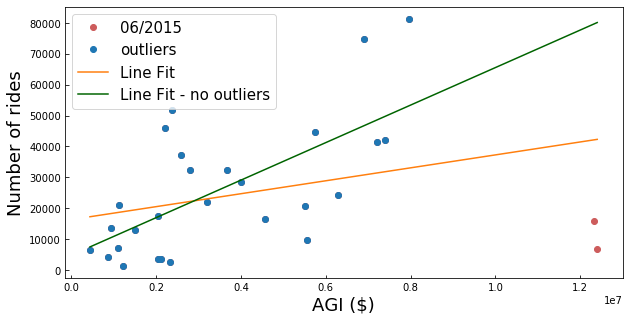

In [22]:
# reducting the data by cutting on income ,1.2e7
# fit line to refucted data
linmodel_cut2015 = smf.ols(formula = 'Nrides ~ income', data = cbincome2015[cbincome2015.income<1.2e7]).fit()

ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['income'], cbincome2015['Nrides'], 'o', color="IndianRed",  label="06/2015")
ax.plot(cbincome2015[cbincome2015.income<1.2e7]['income'], 
        cbincome2015[cbincome2015.income<1.2e7]['Nrides'], 'o', label="outliers")

ax.plot(np.linspace(cbincome2015.income.min(), cbincome2015.income.max(), 100), 
        linmodel2015.predict(exog = dict(income=np.linspace(cbincome2015.income.min(), 
                                                        cbincome2015.income.max(),100))), 
        label="Line Fit")
ax.plot(np.linspace(cbincome2015.income.min(), cbincome2015.income.max(), 100), 
        linmodel_cut2015.predict(exog = dict(income=np.linspace(cbincome2015.income.min(), 
                                                        cbincome2015.income.max(),100))), 
        label="Line Fit - no outliers", color="DarkGreen")
ax.set_xlabel("AGI ($)", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)
ax.legend(fontsize=15, loc=2)

# fit summary
linmodel_cut2015.summary()

### Figure 3: As Figure 1, but with two outliers, identified by their influence on the line fit, plotted as red dots, and with the OLS line fit to the reducted data (green line). The variance explained by a line fit increased from ~10% to ~40%. The slope changed from 0.02/dollar to 0.06/dollar.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     9.880
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           0.000741
Time:                        22:38:28   Log-Likelihood:                -298.71
No. Observations:                  27   AIC:                             603.4
Df Residuals:                      24   BIC:                             607.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         1.226e+04   1.04e+04      1.183      0.249     -9131.395  3.36e+04
income               0.0007      0.006      0.108      0.915        -0.012     0.014
I((income) ** 2)  6.552e-10   7.59e-10      0.864      0.396      -9.1e-10  2.22e-09
==============================================================================
Omnibus:                        2.164   Durbin-Watson:                   1.115
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                1.912
Skew:                           0.598   Prob(JB):                        0.384
Kurtosis:                       2.483   Cond. No.                     8.43e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

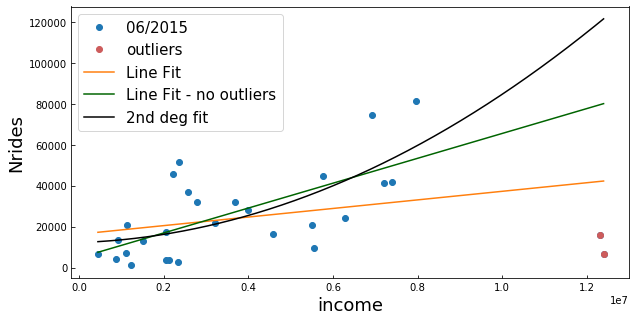

In [23]:
#reducting the imncome with .drop([17,18])
curvmodel15_income = smf.ols(formula = "Nrides ~ income + I((income)**2)", data=cbincome2015.drop([17,18])).fit()

ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['income'], cbincome2015['Nrides'], 'o', label="06/2015")
ax.plot(cbincome2015.iloc[[17,18]]['income'], 
        cbincome2015.iloc[[17,18]]['Nrides'], 'o', label="outliers", color="IndianRed")

ax.plot(np.linspace(cbincome2015.income.min(), cbincome2015.income.max(), 100), 
        linmodel2015.predict(exog = dict(income=np.linspace(cbincome2015.income.min(), 
                                                        cbincome2015.income.max(),100))), 
        label="Line Fit")
ax.plot(np.linspace(cbincome2015.income.min(), cbincome2015.income.max(), 100), 
        linmodel_cut2015.predict(exog = dict(income=np.linspace(cbincome2015.income.min(), 
                                                        cbincome2015.income.max(),100))), 
        label="Line Fit - no outliers", color="DarkGreen")
ax.set_xlabel("AGI ($)", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)
cbincome2015.drop([17,18]).plot(kind="scatter", x='income', y='Nrides', ax=ax)
x = np.linspace(cbincome2015.income.min(), cbincome2015.income.max(), 1000)
ax.plot(x, curvmodel15_income.predict(exog = dict(income=x)), '-', color="k", label="2nd deg fit")
ax.legend(fontsize=15, loc=2)
curvmodel15_income.summary()

### Figure 4: as figure 1 and 3 with the model generated by a second degree polynomial fit to the reducted data plotted in black. The second degree polynomial is not an improved fit according to the decreased adjusted $R^2$ which went from 0.40 to 0.39 

### A likelihood ratio test can be o preformed to assess if the augmented model is justified by the data. We set a statical significance threshold of 5%

In [24]:
alpha = 0.05
LR = curvmodel15_income.compare_lr_test(curvmodel15_income)

print ("LR test:", LR)

print ("We ", end="")
if LR[0] < 3.84: #0.05 level for 1 DOF chi sq distribution 
    print ("CANNOT ", end="") 
    
print ("reject the Null hypothesis that the restricted (linear) " + 
       "model is better than the 2nd degree polynomial fit with p-value ", end="")
print ("p < %.2f"%alpha)


LR test: (-0.0, nan, 0.0)
We CANNOT reject the Null hypothesis that the restricted (linear) model is better than the 2nd degree polynomial fit with p-value p < 0.05


### Repeating the analysis with 2016/01 data

In [25]:
#alternative to save time
stid2zip = get_jsonparsed_data("http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationsZips2016.json")
cb2016['zipcodes'] = cb2016['start station id'].astype(str).map(stid2zip)

In [26]:
cbgroup16 = cb2016.groupby('zipcodes', as_index=False).count()
cbincome2016 = pd.merge(cbgroup16, zipincome, on="zipcodes", how="inner").drop(cbgroup15.columns[2:], axis=1)
cbincome2016.rename(columns={"tripduration":"Nrides"}, inplace=True)
cbincome2016.head()

,zipcodes,Nrides,income,N,Njoint,Ndeps,incomePC
0,10001,33437,2363960,14080,2410,3250,119.754813
1,10002,26059,2215542,43370,11040,19160,30.114748
2,10003,46760,6910992,29810,5460,4790,172.516026
3,10004,4828,925417,2540,840,1130,205.192239
4,10005,4137,5545849,5890,1340,1340,647.123571


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.894
Date:                Tue, 08 Nov 2016   Prob (F-statistic):             0.0554
Time:                        22:39:02   Log-Likelihood:                -451.48
No. Observations:                  42   AIC:                             907.0
Df Residuals:                      40   BIC:                             910.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   7384.9429   2776.149      2.660      0.011      1774.136   1.3e+04
income         0.0010      0.001      1.973      0.055     -2.45e-05     0.002
==============================================================================
Omnibus:                       10.874   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.497
Skew:                           1.166   Prob(JB):                      0.00526
Kurtosis:                       3.750   Cond. No.                     8.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

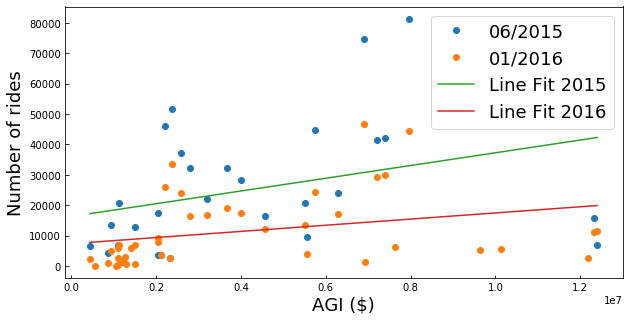

In [27]:
# line fit to 2016 AGI
linmodel2016 = smf.ols(formula = 'Nrides ~ income', data = cbincome2016).fit()

#plot data and fits
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['income'], cbincome2015['Nrides'], 'o', label="06/2015")
ax.plot(cbincome2016['income'], cbincome2016['Nrides'], 'o', label="01/2016")

ax.plot(np.linspace(cbincome2016.income.min(), cbincome2016.income.max(), 100), 
        linmodel2015.predict(exog = dict(income=np.linspace(cbincome2016.income.min(), 
                                                        cbincome2016.income.max(),100))), 
        label="Line Fit 2015")

ax.plot(np.linspace(cbincome2016.income.min(), cbincome2016.income.max(), 100), 
        linmodel2016.predict(exog = dict(income=np.linspace(cbincome2016.income.min(), 
                                                        cbincome2016.income.max(),100))), 
        label="Line Fit 2016")
ax.set_xlabel("AGI ($)", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)
ax.legend(fontsize=18)
linmodel2016.summary()


### Figure 5:  2015/06 and 2016/01 plotted in blue and orange respectively. The 2016 dataset shows more datapoints (corresponding to new citibike stations) in the low ridership-high income region where we had identified two outliers. This  invalidates our outlier classification: the high income-low ridership is a feature of the data. Correspondingly, the line fit (blue line for fit to the whole 2015 data, red line for fit to the whole 2016 data) has a lower slope (0.001 ridership change per dollar change) still though with low explanatory power, explaining a variance of less than 10%. The ridership is also generally lower, and this feature of the 2016 dataset is easily explained with a seasonal effect: fewer people ride in the colder, winter months.

# income per person

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                   0.01073
Date:                Tue, 08 Nov 2016   Prob (F-statistic):              0.918
Time:                        22:39:11   Log-Likelihood:                -329.03
No. Observations:                  29   AIC:                             662.1
Df Residuals:                      27   BIC:                             664.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.433e+04   6710.372      3.626      0.001      1.06e+04  3.81e+04
incomePC       3.1327     30.246      0.104      0.918       -58.927    65.193
==============================================================================
Omnibus:                        8.086   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                6.516
Skew:                           1.108   Prob(JB):                       0.0385
Kurtosis:                       3.696   Cond. No.                         378.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

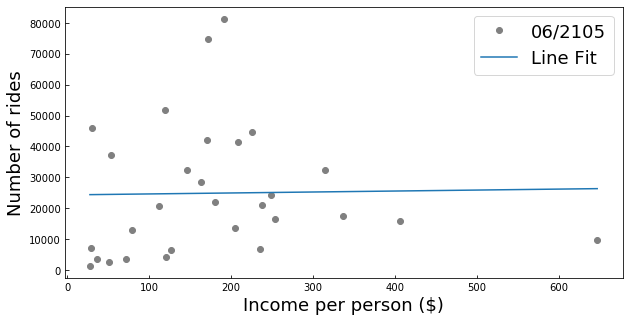

In [28]:
# fit to income per person 2015
linmodelPC2015 = smf.ols(formula = 'Nrides ~ incomePC', data = cbincome2015).fit()

#plot 
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['incomePC'], cbincome2015['Nrides'], 'o', label="06/2105", color="grey")

ax.plot(np.linspace(cbincome2015.incomePC.min(), cbincome2015.incomePC.max(), 100), 
        linmodelPC2015.predict(exog = dict(incomePC=np.linspace(cbincome2015.incomePC.min(), 
                                                        cbincome2015.incomePC.max(),100))), 
        label="Line Fit")
ax.set_xlabel("Income per person ($)", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)
ax.legend(fontsize=18)

linmodelPC2015.summary()

### Figure 6: Number of rides as a function of income per person, obtained by dividing the AGI by the number of returns (accounting for joint returns) and number of dependents (grey dots) and OLS line fit (blue line). The upward slope is lost and so is all of the explainatory power of income ($R^2 = 0$): while the total gross income of a zipcode is a (somwehat weak) predictor of ridership the income per person has no predictive power. This may be due to a dependency of income on the "hidden variable" zipcode population. To test this we can fit the reidership to population and see if we recover the predictive power of AGI.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.308
Date:                Tue, 08 Nov 2016   Prob (F-statistic):              0.263
Time:                        22:39:53   Log-Likelihood:                -328.35
No. Observations:                  29   AIC:                             660.7
Df Residuals:                      27   BIC:                             663.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.773e+04   7349.950      2.413      0.023      2652.537  3.28e+04
population     0.2462      0.215      1.144      0.263        -0.195     0.688
==============================================================================
Omnibus:                        5.543   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                3.950
Skew:                           0.861   Prob(JB):                        0.139
Kurtosis:                       3.550   Cond. No.                     6.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

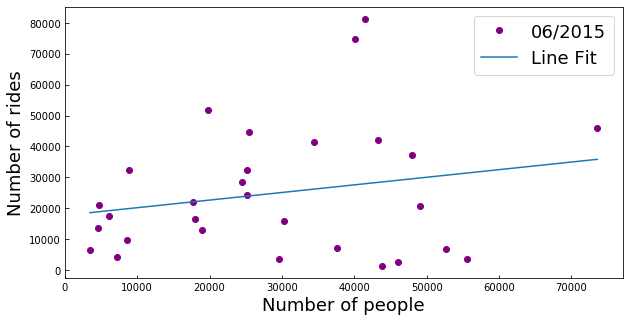

In [30]:
cbincome2015['population'] = (cbincome2015.N + cbincome2015.Ndeps + cbincome2015.Njoint)
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.plot(cbincome2015['population'], cbincome2015['Nrides'], 'o', label="06/2015", color="Purple")

linmodelPOP2015 = smf.ols(formula = 'Nrides ~ population', data = cbincome2015).fit()
ax.plot(np.linspace(cbincome2015.population.min(), cbincome2015.population.max(), 100), 
        linmodelPOP2015.predict(exog = dict(population=np.linspace(cbincome2015.population.min(), 
                                                        cbincome2015.population.max(),100))), 
        label="Line Fit")
ax.set_xlabel("Number of people", fontsize=18)
ax.set_ylabel("Number of rides", fontsize=18)
ax.legend(fontsize=18)
linmodelPOP2015.summary()


### Figure 7: Number of Citibike Rides in 2015/06 as a function of zipcode population (purple dots). The blue line is the line fit obtained with ordinary least square (OLS) method. The model explains  ~5% of the variance in the data, about a half of the variance explained by the AGI linear model.